In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"mohamedtarek01","key":"665e66fa10ef6564c285ceb474fe2baa"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c mtcaic3 -p /content/aic3 --force


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
import os
print(os.listdir("/content/aic3"))


['mtcaic3.zip', 'unzipped']


In [ ]:
import zipfile
import os

zip_path = "/content/aic3/mtcaic3.zip"
extract_path = "/content/aic3/unzipped"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction done. Files inside the unzipped folder:")
print(os.listdir(extract_path))


FileNotFoundError: [Errno 2] No such file or directory: '/content/aic3/mtcaic3.zip'

In [ ]:
import shutil

drive_path = "/content/drive/MyDrive/aic3"
os.makedirs(drive_path, exist_ok=True)

shutil.move(extract_path, drive_path)

print("Files moved to Google Drive at:")
print(os.listdir(drive_path))


Files moved to Google Drive at:
['unzipped']


***MTC-AIC3 BCI Competition:***

This notebook executes your provided script, adding detailed visualizations and the necessary components for competition submission at each logical stage. The core technical methodology remains identical to your original code.

***Section 0 & 1: Setup and Data Loading***

This initial section handles all the necessary preparations for our analysis. It starts by importing the required Python libraries for data manipulation (pandas, numpy), signal processing (scipy), machine learning (sklearn), and plotting (matplotlib, seaborn). It then defines key constants and paths. Finally, it loads the train, validation, and test metadata from CSV files and filters them to include only the 'SSVEP' task trials.

In [ ]:
# ===================================================================
# Section 0 & 1: Setup and Data Loading
# ===================================================================

# --- Library Imports ---
# Import pandas for data manipulation and analysis (e.g., reading CSVs, creating DataFrames).
import pandas as pd
# Import numpy for numerical operations, especially with arrays.
import numpy as np
# Import os for interacting with the operating system, used here for building file paths.
import os
# Import signal processing functions from scipy: 'butter' to design a Butterworth filter,
# 'filtfilt' for zero-phase filtering, and 'welch' for Power Spectral Density (PSD) estimation.
from scipy.signal import butter, filtfilt, welch
# Import preprocessing tools from scikit-learn: 'MinMaxScaler' to normalize features to a [0, 1] range
# and 'LabelEncoder' to convert categorical labels (like 'F1', 'F2') into numerical format.
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# Import RandomForestClassifier, a powerful ensemble learning model for classification.
from sklearn.ensemble import RandomForestClassifier
# Import metrics to evaluate model performance.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Import matplotlib.pyplot for creating static, animated, and interactive visualizations.
import matplotlib.pyplot as plt
# Import seaborn, a high-level plotting library based on matplotlib, for more attractive statistical graphics.
import seaborn as sns
# Import tqdm for displaying smart progress bars, which is helpful for long-running processes.
from tqdm.notebook import tqdm
# Import tools for hyperparameter tuning and cross-validation.
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# Import a feature selection tool that removes features based on importance weights.
from sklearn.feature_selection import SelectFromModel
# Import warnings to control how warning messages are handled (we will ignore them for cleaner output).
import warnings

# Configure warnings to be ignored to prevent cluttering the output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

# --- Path and constants ---
# !!! IMPORTANT: Please update this path to your Google Drive location or local folder !!!
# This is the root directory where the competition data is stored.
BASE_PATH = '/content/drive/MyDrive/aic3/unzipped'
# Specify the task we are focusing on in this notebook.
TASK_TO_PROCESS = 'SSVEP'
# Define the specific EEG channels we will use for our analysis. These are typically in the occipital lobe region.
EEG_CHANNELS = ['PO7', 'PZ', 'OZ', 'PO8']
# The sampling rate of the EEG data in Hertz (Hz).
SAMPLING_RATE = 250
# The target frequencies (in Hz) that were shown to the subjects during the SSVEP experiment.
TARGET_FREQS = [7, 8, 10, 13]
# The total duration of each trial in seconds.
TRIAL_DURATION_S = 7.0
# The duration in seconds to trim from the beginning of each trial to remove initial artifacts.
TIME_TRIM_S = 1.0

# --- Data Loading ---
try:
    # Load the main metadata files.
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

    # Filter the DataFrames to keep only the rows corresponding to the SSVEP task.
    # .reset_index(drop=True) is used to create a new clean index for the filtered DataFrame.
    train_ssvep_df = train_df[train_df['task'] == TASK_TO_PROCESS].reset_index(drop=True)
    val_ssvep_df = validation_df[validation_df['task'] == TASK_TO_PROCESS].reset_index(drop=True)
    test_ssvep_df = test_df[test_df['task'] == TASK_TO_PROCESS].reset_index(drop=True)
    print(f"Loaded {len(train_ssvep_df)} training, {len(val_ssvep_df)} validation, and {len(test_ssvep_df)} test trials for SSVEP task.")
except FileNotFoundError:
    # Error handling in case the files are not found at the specified path.
    print("="*80)
    print("!!! ERROR: Data files not found. Please ensure BASE_PATH is correct !!!")
    print(f"Current BASE_PATH: '{BASE_PATH}'")
    print("="*80)
    # exit() # This would stop the script. We comment it out to allow execution in environments where data might be loaded differently.

Libraries imported successfully.
Loaded 2400 training, 50 validation, and 50 test trials for SSVEP task.


***Visualization 1: Initial Data Exploration***

Before any processing, let's inspect our data. We will first visualize the distribution of labels in the training and validation sets to ensure they are balanced. Then, we will plot the raw EEG signals from a single trial to understand what our input data looks like.


--- Visualizing Initial Data ---


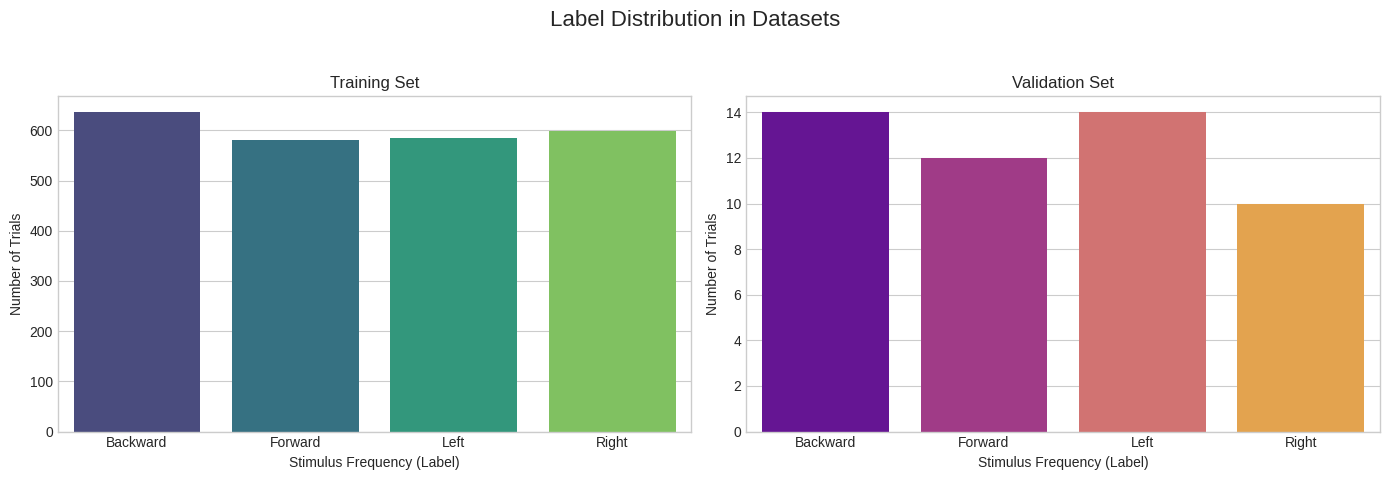

In [ ]:
# --- Plot 1: Label Distribution ---
print("\n--- Visualizing Initial Data ---")
# Create a figure with two subplots side-by-side.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Label Distribution in Datasets', fontsize=16)

# Plot for the training set.
sns.countplot(data=train_ssvep_df, x='label', ax=ax1, palette='viridis', order=sorted(train_ssvep_df['label'].unique()))
ax1.set_title('Training Set')
ax1.set_xlabel('Stimulus Frequency (Label)')
ax1.set_ylabel('Number of Trials')

# Plot for the validation set.
sns.countplot(data=val_ssvep_df, x='label', ax=ax2, palette='plasma', order=sorted(val_ssvep_df['label'].unique()))
ax2.set_title('Validation Set')
ax2.set_xlabel('Stimulus Frequency (Label)')
ax2.set_ylabel('Number of Trials')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

***Section 2: Core Pipeline Functions***

This section defines the core functions that form our data processing pipeline.
load_trial_data: Reads a specific trial's EEG data from its CSV file, handling path construction and selecting the correct segment based on trial number. It also trims the beginning of the trial to remove potential noise.
apply_butterworth_filter: Applies a band-pass filter to the EEG data. This is crucial for removing low-frequency drift and high-frequency noise (like muscle artifacts and power line interference), isolating the brain signals in the frequency range of interest (4-42 Hz).
extract_psd_features: This is the feature extraction step. It calculates the Power Spectral Density (PSD) using Welch's method. For each target frequency and its harmonics, it extracts two key features: the signal power at that specific frequency and the Signal-to-Noise Ratio (SNR), which compares the signal power to the power of the surrounding "noise" frequencies.

In [ ]:
# ===================================================================
# Section 2: Core Pipeline Functions
# ===================================================================

def load_trial_data(row, base_path):
    """
    Loads the EEG data for a single trial specified by a row from the metadata DataFrame.
    It identifies the dataset (train/validation/test) based on the 'id', constructs the file path,
    and loads the corresponding EEGdata.csv file. It then segments and trims the data for the specific trial.
    """
    # Determine which dataset folder (train, validation, or test) the trial belongs to.
    id_num = row['id']
    if 1 <= id_num <= 4800: dataset_type = 'train'
    elif 4801 <= id_num <= 4900: dataset_type = 'validation'
    else: dataset_type = 'test'
    # Construct the full path to the EEGdata.csv file for the trial.
    path = f"{base_path}/{row['task']}/{dataset_type}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    # Load the EEG data.
    eeg_data = pd.read_csv(path)
    # Handle any missing values using forward fill and then backward fill.
    eeg_data = eeg_data.ffill().bfill()
    # Calculate the number of data points (samples) per trial.
    samples_per_trial = int(TRIAL_DURATION_S * SAMPLING_RATE)
    # Calculate the number of samples to trim from the start.
    trim_samples = int(TIME_TRIM_S * SAMPLING_RATE)
    # Get the trial number from the metadata row.
    trial_num = int(row['trial'])
    # Calculate the start and end index for this specific trial in the EEGdata.csv file.
    start_idx = (trial_num - 1) * samples_per_trial
    # Adjust the start index to account for the trim.
    trimmed_start_idx = start_idx + trim_samples
    end_idx = start_idx + samples_per_trial
    # Return the trimmed segment of the EEG data.
    return eeg_data.iloc[trimmed_start_idx:end_idx]

def apply_butterworth_filter(data, fs=250):
    """
    Applies a 4th order Butterworth band-pass filter to the data.
    The filter is designed to pass frequencies between 4.0 Hz and 42.0 Hz.
    'filtfilt' is used for zero-phase filtering, which prevents phase distortion.
    """
    lowcut, highcut, order = 4.0, 42.0, 4
    # Nyquist frequency is half the sampling rate.
    nyq = 0.5 * fs
    # Normalize the cutoff frequencies.
    low, high = lowcut / nyq, highcut / nyq
    # Get the filter coefficients (numerator 'b' and denominator 'a').
    b, a = butter(order, [low, high], btype='band')
    # Apply the filter along the columns (axis=0).
    # A check is included to handle constant-value signals, which would cause filtfilt to fail.
    filtered_data = np.apply_along_axis(lambda x: filtfilt(b, a, x) if not np.all(x == x[0]) else x, 0, data)
    return filtered_data

def extract_psd_features(data, fs=250):
    """
    Extracts features based on the Power Spectral Density (PSD) of the signal.
    It uses Welch's method to estimate the PSD. For each of the target SSVEP frequencies
    and their first three harmonics, it calculates the signal power and the SNR.
    """
    all_features = []
    # Define the length of each segment for Welch's method (4 seconds of data).
    nperseg = fs * 4
    # Iterate through each EEG channel (columns of the data).
    for i in range(data.shape[1]):
        channel_data = data[:, i]
        # Calculate PSD using Welch's method. nfft is set to be twice the segment length
        # for better frequency resolution.
        freqs, psd = welch(channel_data, fs=fs, nperseg=nperseg, nfft=nperseg*2)
        # Iterate through each target frequency (e.g., 7 Hz, 8 Hz, ...).
        for f in TARGET_FREQS:
            # Iterate through the fundamental frequency (h=1) and its harmonics (h=2, 3).
            for h in range(1, 4):
                harmonic_freq = h * f
                # Find the index of the frequency in 'freqs' that is closest to our target harmonic.
                target_idx = np.argmin(np.abs(freqs - harmonic_freq))
                # Define the noise band as frequencies within +/- 3 Hz of the harmonic, excluding a small window around the signal itself.
                noise_indices = np.where((freqs >= harmonic_freq - 3) & (freqs <= harmonic_freq + 3) & (np.abs(freqs - harmonic_freq) > 0.25))[0]
                # The signal power is the PSD value at the target frequency index.
                signal_power = psd[target_idx]
                # The noise power is the average of the PSD values in the defined noise band.
                noise_power = np.mean(psd[noise_indices]) if len(noise_indices) > 0 else 1e-12 # Add a small value to avoid division by zero.
                # Calculate the Signal-to-Noise Ratio (SNR).
                snr = signal_power / noise_power
                # Append the calculated features to our list.
                all_features.append(signal_power)
                all_features.append(snr)
    return np.array(all_features)

***Visualization 2: Pre-processing and Feature Extraction Steps***

Now, let's visualize the effect of our key processing functions using a sample trial.
Raw vs. Filtered Signal: We'll plot a channel's raw signal against its filtered version to see how the Butterworth filter cleans the data.
Power Spectral Density (PSD): We'll plot the PSD of the filtered signal. This shows the signal's power at different frequencies and is the basis for our feature extraction. We'll mark the target frequencies to show where we're looking for SSVEP responses.


--- Visualizing Preprocessing and Feature Extraction Steps ---
Available labels in the SSVEP training set are: ['Forward' 'Left' 'Backward' 'Right']
Selecting a sample trial with label: 'Forward'


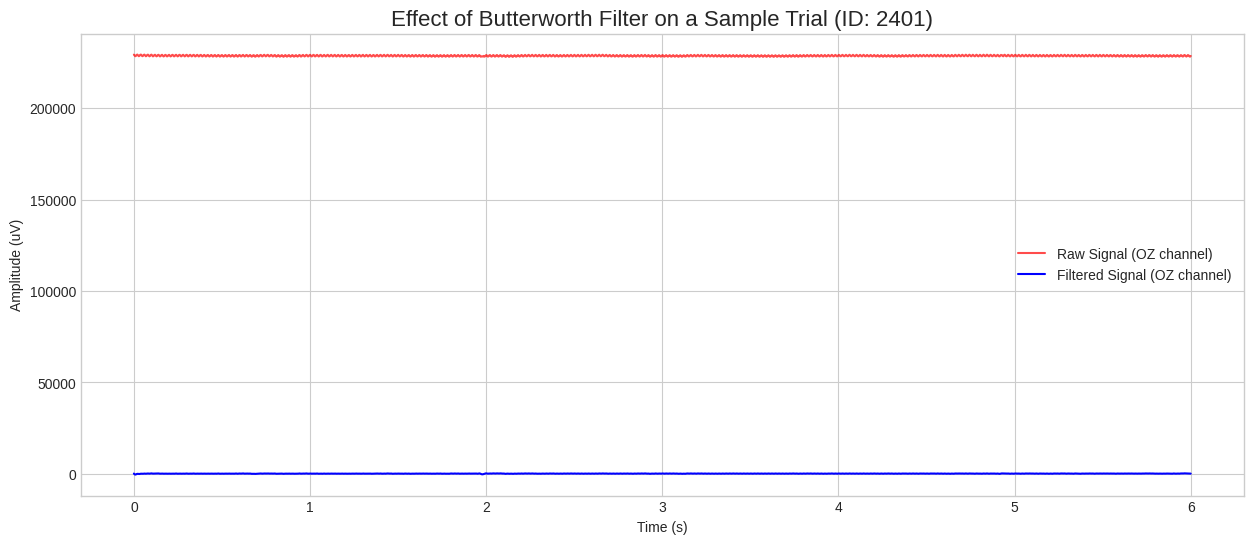

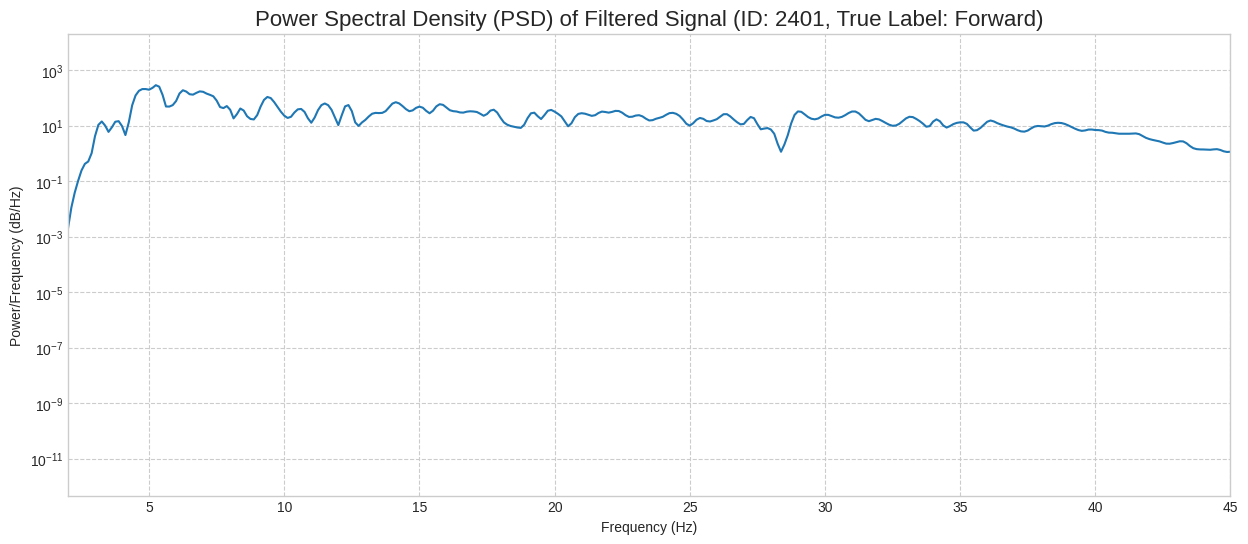

In [ ]:
# --- Visualizing the pipeline steps on a sample trial ---
print("\n--- Visualizing Preprocessing and Feature Extraction Steps ---")

# =====================================================================================
# DIAGNOSTIC STEP: Let's find out what the actual unique labels are in our dataset.
# This will prevent us from trying to use a label that doesn't exist.
# =====================================================================================
available_labels = train_ssvep_df['label'].unique()
print(f"Available labels in the SSVEP training set are: {available_labels}")

# =====================================================================================
# CORRECTED LINE: Now we select a sample using a label that we KNOW exists.
# We'll take the first available label from the list we just generated.
# =====================================================================================
sample_label_to_use = available_labels[0]
sample_row = train_ssvep_df[train_ssvep_df['label'] == sample_label_to_use].iloc[0]
print(f"Selecting a sample trial with label: '{sample_label_to_use}'")


# --- The rest of the code remains the same and will now work correctly ---
sample_raw_data = load_trial_data(sample_row, BASE_PATH)
sample_raw_signals = sample_raw_data[EEG_CHANNELS].values

# --- Plot 2: Raw vs. Filtered EEG Signal ---
# Apply the filter to the sample data
sample_filtered_signals = apply_butterworth_filter(sample_raw_signals)

# Create a time axis for plotting
time_axis = np.linspace(0, sample_raw_signals.shape[0] / SAMPLING_RATE, sample_raw_signals.shape[0])

# Plotting the 'OZ' channel, which is often strong for visual stimuli
channel_to_plot_idx = EEG_CHANNELS.index('OZ')
plt.figure(figsize=(15, 6))
plt.plot(time_axis, sample_raw_signals[:, channel_to_plot_idx], label='Raw Signal (OZ channel)', color='red', alpha=0.7)
plt.plot(time_axis, sample_filtered_signals[:, channel_to_plot_idx], label='Filtered Signal (OZ channel)', color='blue', linewidth=1.5)
plt.title(f"Effect of Butterworth Filter on a Sample Trial (ID: {sample_row['id']})", fontsize=16)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 3: Power Spectral Density (PSD) ---
# Calculate the PSD for the filtered 'OZ' channel signal
freqs, psd = welch(sample_filtered_signals[:, channel_to_plot_idx], fs=SAMPLING_RATE, nperseg=SAMPLING_RATE * 4, nfft=SAMPLING_RATE*8)

plt.figure(figsize=(15, 6))
plt.semilogy(freqs, psd, label='PSD of Filtered Signal') # Use a log scale for the y-axis to see peaks better
plt.title(f"Power Spectral Density (PSD) of Filtered Signal (ID: {sample_row['id']}, True Label: {sample_row['label']})", fontsize=16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.xlim(2, 45) # Limit x-axis to the frequency range of interest
plt.grid(True, which="both", ls="--")


***Section 3: Building the Dataset***

This section applies the processing pipeline to every trial in the train, validation, and test sets. It iterates through each row of the metadata DataFrames (train_ssvep_df, val_ssvep_df, test_ssvep_df), calls the functions defined in Section 2 (load_trial_data, apply_butterworth_filter, extract_psd_features), and compiles the results into feature matrices (X_train, X_val, X_test) and label vectors (y_train, y_val). The tqdm library provides a helpful progress bar to monitor this process.

In [ ]:
# ===================================================================
# Section 3: Building the Dataset
# ===================================================================

def process_dataframe(df, base_path):
    """
    Processes an entire DataFrame (train, validation, or test) to extract features and labels.
    It loops through each trial, applies the loading, filtering, and feature extraction pipeline,
    and returns the complete feature matrix (X) and label vector (y).
    """
    feature_list, label_list = [], []
    # Set a description for the progress bar based on the DataFrame's name.
    desc = f"Processing {df.name}"
    # Use tqdm to create a progress bar for the loop.
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        # 1. Load the raw trial data.
        trial_data = load_trial_data(row, base_path)
        eeg_signals = trial_data[EEG_CHANNELS].values
        # 2. Apply the band-pass filter.
        filtered_signals = apply_butterworth_filter(eeg_signals)
        # 3. Extract PSD features from the filtered signals.
        features = extract_psd_features(filtered_signals)
        feature_list.append(features)
        # If the DataFrame has a 'label' column (i.e., it's train or validation), store the label.
        if 'label' in df.columns:
            label_list.append(row['label'])
    # Convert the list of feature arrays into a single 2D numpy array.
    X = np.array(feature_list)
    # Convert the list of labels into a numpy array if it exists.
    y = np.array(label_list) if label_list else None
    print(f"Finished processing {df.name}. Extracted features for {len(feature_list)} trials.")
    return X, y

# Assign names to the DataFrames for clearer progress bar descriptions.
train_ssvep_df.name, val_ssvep_df.name, test_ssvep_df.name = "Train", "Validation", "Test"

# Process each dataset to create the final feature matrices and labels.
X_train, y_train = process_dataframe(train_ssvep_df, BASE_PATH)
X_val, y_val = process_dataframe(val_ssvep_df, BASE_PATH)
X_test, _ = process_dataframe(test_ssvep_df, BASE_PATH)

Processing Train:   0%|          | 0/2400 [00:00<?, ?it/s]

Finished processing Train. Extracted features for 2400 trials.


Processing Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Finished processing Validation. Extracted features for 50 trials.


Processing Test:   0%|          | 0/50 [00:00<?, ?it/s]

Finished processing Test. Extracted features for 50 trials.


***Section 4: Improved Training with Aggressive Regularization***

This section prepares the data for modeling and then trains a RandomForest classifier.
Scaling and Encoding:
MinMaxScaler: Normalizes the features to a range of [0, 1]. This is important for many ML algorithms, ensuring that features with larger value ranges don't dominate the model.
LabelEncoder: Converts the string labels (e.g., 'F1', 'F2') into integer representations (e.g., 0, 1), which are required by the model.
Feature Selection: A preliminary RandomForest model is trained to assess feature importance. SelectFromModel then automatically removes the less important features (those with importance below the median), reducing model complexity and potentially improving generalization.
Hyperparameter Tuning:
RandomizedSearchCV: Instead of testing every possible combination of hyperparameters, this efficiently searches for the best combination from a given distribution.
Aggressive Regularization: The hyperparameter grid is intentionally designed to prevent overfitting. It forces the model's trees to be "shallow" (max_depth) and to require more data points to make a decision (min_samples_leaf), which helps the model learn more general patterns.
StratifiedKFold: This cross-validation strategy ensures that each fold has the same proportion of labels as the original dataset, which is crucial for imbalanced or small datasets.

In [ ]:
# ===================================================================
# Section 4: Improved Training with AGGRESSIVE REGULARIZATION
# ===================================================================

# --- Scaling and Encoding ---
# Initialize the MinMaxScaler to scale features to the [0, 1] range.
scaler = MinMaxScaler()
# Fit the scaler on the training data and transform it.
X_train_scaled = scaler.fit_transform(X_train)
# Apply the SAME fitted scaler to transform the validation and test data.
# This prevents data leakage from the validation/test sets into the training process.
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize the LabelEncoder to convert string labels to integers.
label_encoder = LabelEncoder()
# Fit the encoder on the training labels and transform them.
y_train_encoded = label_encoder.fit_transform(y_train)
# Apply the SAME fitted encoder to the validation labels.
y_val_encoded = label_encoder.transform(y_val)
print("\nData normalization and encoding complete.")


Data normalization and encoding complete.


***Visualization 3: Effect of Feature Scaling***

Let's see how MinMaxScaler changed the distribution of our features. We'll plot the density of a few features before and after scaling.


--- Visualizing Effect of Feature Scaling ---


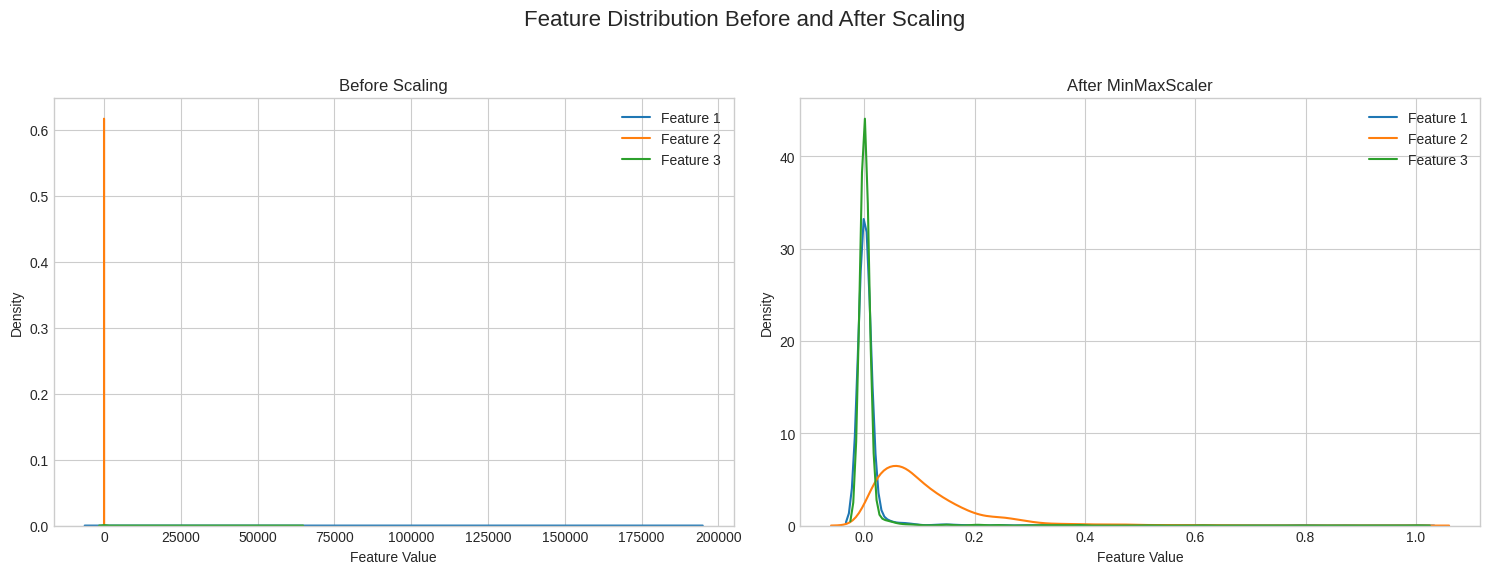

In [ ]:
# --- Plot 4: Feature Scaling Distribution ---
print("\n--- Visualizing Effect of Feature Scaling ---")
plt.figure(figsize=(15, 6))
plt.suptitle('Feature Distribution Before and After Scaling', fontsize=16)

# Plot distribution before scaling for the first 3 features
plt.subplot(1, 2, 1)
for i in range(3):
    sns.kdeplot(X_train[:, i], label=f'Feature {i+1}')
plt.title('Before Scaling')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()

# Plot distribution after scaling for the first 3 features
plt.subplot(1, 2, 2)
for i in range(3):
    sns.kdeplot(X_train_scaled[:, i], label=f'Feature {i+1}')
plt.title('After MinMaxScaler')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# --- Feature Selection ---
print("\nPerforming feature selection...")
# We first train a RandomForestClassifier to get feature importances.
# n_jobs=-1 uses all available CPU cores to speed up training.
sel_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
sel_clf.fit(X_train_scaled, y_train_encoded)

# Initialize SelectFromModel, which will select features whose importance is greater than a specified threshold.
# Here, 'median' means it will keep the top 50% most important features.
# prefit=True indicates that we are using a model that has already been trained.
selector = SelectFromModel(sel_clf, prefit=True, threshold='median')

# Transform the datasets to keep only the selected features.
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)
print(f"Selected {X_train_selected.shape[1]} features out of {X_train_scaled.shape[1]}.")


Performing feature selection...
Selected 48 features out of 96.


***Visualization 4: Feature Importances***

Let's visualize the importances that the feature selection model learned. This helps us understand which features were considered most useful for the classification task.


--- Visualizing Feature Importances for Selection ---


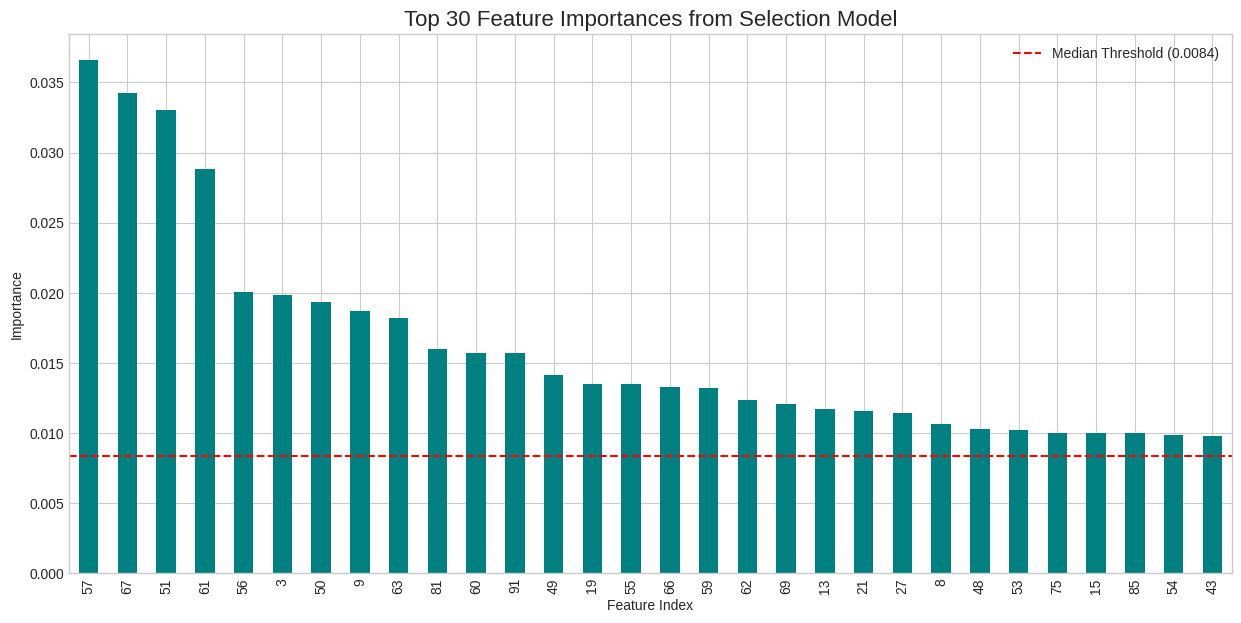

In [ ]:
# --- Plot 5: Feature Importances ---
print("\n--- Visualizing Feature Importances for Selection ---")
# Get the feature importances from the classifier used for selection
importances = sel_clf.feature_importances_
# Create a pandas Series for easier handling and plotting
feat_importances = pd.Series(importances).sort_values(ascending=False)
# Get the threshold value used by SelectFromModel
threshold_value = np.median(importances)

plt.figure(figsize=(15, 7))
# Plot only the top 30 most important features for clarity
feat_importances.head(30).plot(kind='bar', color='teal')
# Draw a horizontal line representing the selection threshold
plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Median Threshold ({threshold_value:.4f})')
plt.title('Top 30 Feature Importances from Selection Model', fontsize=16)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.legend()
plt.show()

In [ ]:
# --- IMPROVEMENT: More AGGRESSIVE Hyperparameter Grid to force generalization ---
print("\nPerforming hyperparameter tuning with AGGRESSIVE regularization...")
# Define the parameter distribution for RandomizedSearchCV.
# These ranges are chosen to build a more robust, less overfit model.
param_dist = {
    'n_estimators': [50, 100, 150],        # Fewer trees can reduce overfitting.
    'max_depth': [4, 5, 6, 7],             # Crucial: Shallow trees are less complex and generalize better.
    'min_samples_leaf': [6, 8, 10, 12],    # Crucial: Requiring more samples in a leaf node prevents the model from learning noise.
    'max_features': ['sqrt', 0.5],         # Limits the number of features considered at each split, another regularization technique.
    'class_weight': ['balanced']           # Helps with class imbalance by adjusting weights inversely proportional to class frequencies.
    # 'class_weight': [{0: 1.10, 1: 1.20, 2: 1.10, 3: 1.05}]
}

# --- Use StratifiedKFold for reliable cross-validation ---
# This ensures that each fold of the cross-validation is representative of the overall label distribution.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Randomized Search ---
# Initialize RandomizedSearchCV with the classifier, parameter grid, and CV strategy.
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=25, # Number of parameter settings that are sampled.
    cv=cv_strategy,
    scoring='accuracy', # The metric to optimize.
    verbose=1, # Prints progress updates.
    random_state=42,
    n_jobs=-1 # Use all available CPU cores.
)
# Start the search process on the selected training data.
random_search.fit(X_train_selected, y_train_encoded)

# After the search is complete, get the best model found.
print("\nBest parameters found:", random_search.best_params_)
best_rf = random_search.best_estimator_


Performing hyperparameter tuning with AGGRESSIVE regularization...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters found: {'n_estimators': 150, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 6, 'class_weight': 'balanced'}


***Section 5: Evaluation and Visualization***

After training the final, optimized model, this section evaluates its performance.
Prediction: The model predicts labels for both the training and validation sets.
Metrics Calculation: accuracy_score and classification_report are used to compute key performance metrics. The classification report provides precision, recall, and F1-score for each class, giving a more detailed view than accuracy alone.
Visualization:
A bar chart compares the final training and validation accuracy. A small gap between these two values suggests the model is generalizing well.
A confusion matrix visualizes the model's performance on the validation set, showing which classes are often confused with each other.


--- Model Evaluation ---

Final Training Accuracy: 67.50%
Final Validation Accuracy: 68.00%

Final Validation Classification Report:
              precision    recall  f1-score   support

    Backward       0.67      0.71      0.69        14
     Forward       0.64      0.75      0.69        12
        Left       0.80      0.57      0.67        14
       Right       0.64      0.70      0.67        10

    accuracy                           0.68        50
   macro avg       0.69      0.68      0.68        50
weighted avg       0.69      0.68      0.68        50



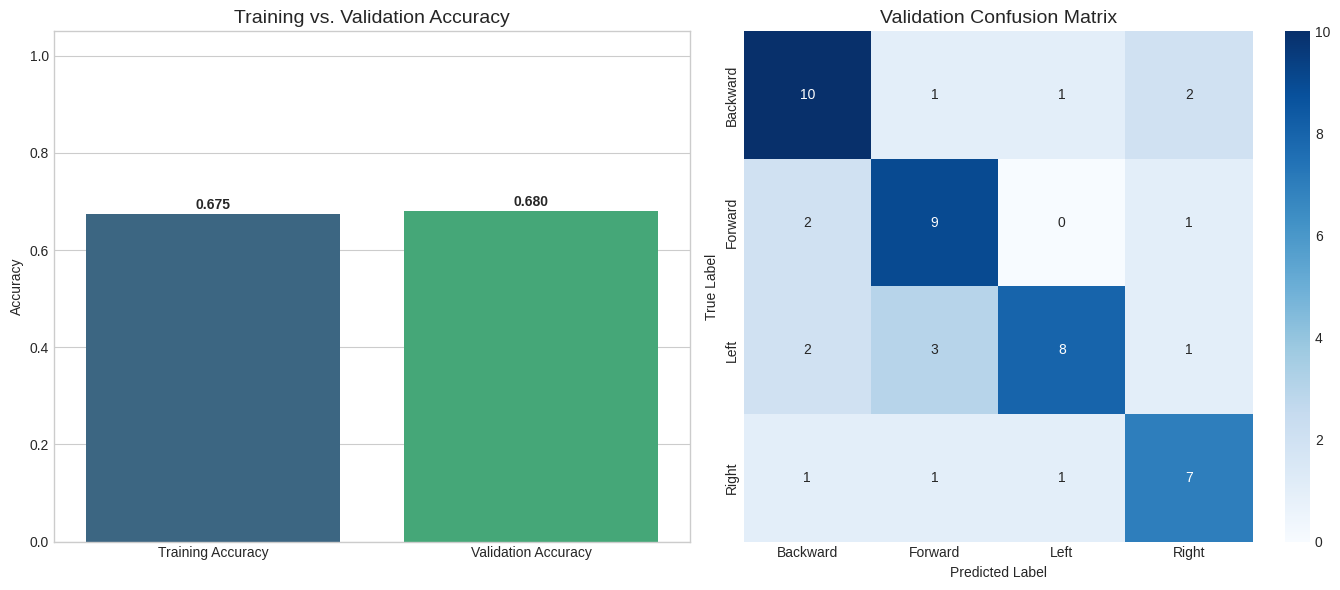

In [ ]:
# ===================================================================
# Section 5: Evaluation and Visualization
# ===================================================================
print("\n--- Model Evaluation ---")
# Predict on the training data to check for overfitting.
y_pred_train = best_rf.predict(X_train_selected)
# Predict on the validation data to assess generalization performance.
y_pred_val = best_rf.predict(X_val_selected)

# Calculate the accuracy scores.
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
val_accuracy = accuracy_score(y_val_encoded, y_pred_val)

print(f"\nFinal Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

# The classification report shows precision, recall, and F1-score for each class.
# - Precision: Of all the predictions for a class, how many were correct? (TP / (TP + FP))
# - Recall: Of all the actual instances of a class, how many did the model find? (TP / (TP + FN))
# - F1-Score: The harmonic mean of precision and recall.
print("\nFinal Validation Classification Report:")
print(classification_report(y_val_encoded, y_pred_val, target_names=label_encoder.classes_))

# --- Plotting ---
# Set a modern plot style.
plt.style.use('seaborn-v0_8-whitegrid')
# Create a figure with two subplots side-by-side.
fig, ax1 = plt.subplots(figsize=(14, 6), ncols=2)

# --- Plot 6: Training vs. Validation Accuracy Bar Chart ---
# This plot provides a quick comparison of performance on seen (train) vs. unseen (validation) data.
sns.barplot(x=['Training Accuracy', 'Validation Accuracy'], y=[train_accuracy, val_accuracy], ax=ax1[0], palette='viridis')
ax1[0].set_title('Training vs. Validation Accuracy', fontsize=14)
ax1[0].set_ylabel('Accuracy')
ax1[0].set_ylim(0, 1.05) # Set y-axis limit to be just above 1.0.
# Add text labels on top of the bars to show the exact values.
for i, v in enumerate([train_accuracy, val_accuracy]):
    ax1[0].text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')

# --- Plot 7: Validation Confusion Matrix ---
# The confusion matrix shows the number of correct and incorrect predictions for each class.
# The diagonal elements show correct predictions. Off-diagonal elements show where errors were made.
cm = confusion_matrix(y_val_encoded, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=ax1[1])
ax1[1].set_title('Validation Confusion Matrix', fontsize=14)
ax1[1].set_xlabel('Predicted Label')
ax1[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

***Section 6: Prediction and Submission***

This final section uses the fully trained and tuned model (best_rf) to make predictions on the unseen test data (X_test_selected). The predicted integer labels are converted back to their original string format (e.g., 'F1', 'F2') using the label_encoder. Finally, a submission file is created in the specified format (id, label) and saved as a CSV file.

In [ ]:
# ===================================================================
# Section 6: Prediction and Submission
# ===================================================================
print("\nGenerating final predictions for the test set...")
# Use the trained model to predict labels for the preprocessed test data.
test_predictions_encoded = best_rf.predict(X_test_selected)
# Convert the numeric predictions back to the original string labels (e.g., 0 -> 'F1').
test_predictions_labels = label_encoder.inverse_transform(test_predictions_encoded)

# Create a new DataFrame for the submission file.
submission_df = pd.DataFrame({'id': test_ssvep_df['id'], 'label': test_predictions_labels})
# Define the filename for the submission file.
submission_filename = 'ssvep_submission_regularized_tuned.csv'
# Save the DataFrame to a CSV file, without the pandas index.
submission_df.to_csv(submission_filename, index=False)

print(f"\nSubmission file '{submission_filename}' created successfully.")
print("Submission file head:")
print(submission_df.head())


Generating final predictions for the test set...

Submission file 'ssvep_submission_regularized_tuned.csv' created successfully.
Submission file head:
     id     label
0  4951  Backward
1  4952  Backward
2  4953   Forward
3  4954  Backward
4  4955  Backward


***Visualization 5: Test Set Prediction Distribution***

As a final sanity check, let's look at the distribution of our model's predictions on the test set. This can sometimes highlight if the model is heavily biased towards one class.


--- Visualizing Test Set Predictions ---


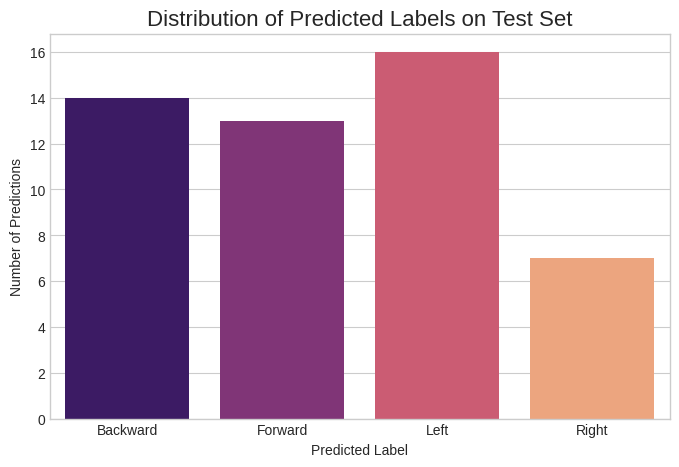

In [ ]:
# --- Plot 8: Test Set Prediction Distribution ---
print("\n--- Visualizing Test Set Predictions ---")
plt.figure(figsize=(8, 5))
sns.countplot(x=submission_df['label'], palette='magma', order=sorted(submission_df['label'].unique()))
plt.title('Distribution of Predicted Labels on Test Set', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('Number of Predictions')
plt.show()

***Deployment Script***

In [ ]:
# Cell 2: Create the training script file
%%writefile train_ssvep.py

import pandas as pd
import numpy as np
import os
import joblib
import warnings
from scipy.signal import butter, filtfilt, welch
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# --- Configuration & Constants ---
warnings.filterwarnings('ignore')
BASE_PATH = '/content/drive/MyDrive/aic3/unzipped' #<--! UPDATE THIS PATH IF NEEDED
MODEL_ARTIFACTS_PATH = 'ssvep_model_artifacts'
TASK_TO_PROCESS = 'SSVEP'
EEG_CHANNELS = ['PO7', 'PZ', 'OZ', 'PO8']
SAMPLING_RATE = 250
TARGET_FREQS = [7, 8, 10, 13]
TRIAL_DURATION_S = 7.0
TIME_TRIM_S = 1.0

# --- Core Pipeline Functions ---
def load_trial_data(row, base_path):
    id_num = row['id']
    if 1 <= id_num <= 4800: dataset_type = 'train'
    elif 4801 <= id_num <= 4900: dataset_type = 'validation'
    else: dataset_type = 'test'
    path = f"{base_path}/{row['task']}/{dataset_type}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    eeg_data = pd.read_csv(path).ffill().bfill()
    samples_per_trial = int(TRIAL_DURATION_S * SAMPLING_RATE)
    trim_samples = int(TIME_TRIM_S * SAMPLING_RATE)
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * samples_per_trial
    trimmed_start_idx = start_idx + trim_samples
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[trimmed_start_idx:end_idx]

def apply_butterworth_filter(data, fs=250):
    lowcut, highcut, order = 4.0, 42.0, 4; nyq = 0.5 * fs; low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return np.apply_along_axis(lambda x: filtfilt(b, a, x) if not np.all(x == x[0]) else x, 0, data)

def extract_psd_features(data, fs=250):
    all_features = []; nperseg = fs * 4
    for i in range(data.shape[1]):
        freqs, psd = welch(data[:, i], fs=fs, nperseg=nperseg, nfft=nperseg*2)
        for f in TARGET_FREQS:
            for h in range(1, 4):
                harmonic_freq = h * f
                target_idx = np.argmin(np.abs(freqs - harmonic_freq))
                noise_indices = np.where((freqs >= harmonic_freq-3)&(freqs<=harmonic_freq+3)&(np.abs(freqs-harmonic_freq)>0.25))[0]
                signal_power = psd[target_idx]
                noise_power = np.mean(psd[noise_indices]) if len(noise_indices) > 0 else 1e-12
                all_features.extend([signal_power, signal_power / noise_power])
    return np.array(all_features)

def process_dataframe(df, base_path, name):
    feature_list, label_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {name}"):
        eeg_signals = load_trial_data(row, base_path)[EEG_CHANNELS].values
        filtered_signals = apply_butterworth_filter(eeg_signals)
        features = extract_psd_features(filtered_signals)
        feature_list.append(features); label_list.append(row['label'])
    return np.array(feature_list), np.array(label_list)

def main():
    print("--- Starting SSVEP Model Training ---")
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    train_ssvep_df = train_df[train_df['task'] == TASK_TO_PROCESS].reset_index(drop=True)
    val_ssvep_df = validation_df[validation_df['task'] == TASK_TO_PROCESS].reset_index(drop=True)
    X_train, y_train = process_dataframe(train_ssvep_df, BASE_PATH, "Train")
    X_val, y_val = process_dataframe(val_ssvep_df, BASE_PATH, "Validation")
    scaler = MinMaxScaler(); X_train_scaled = scaler.fit_transform(X_train); X_val_scaled = scaler.transform(X_val)
    label_encoder = LabelEncoder(); y_train_encoded = label_encoder.fit_transform(y_train); y_val_encoded = label_encoder.transform(y_val)
    sel_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train_scaled, y_train_encoded)
    selector = SelectFromModel(sel_clf, prefit=True, threshold='median')
    X_train_selected = selector.transform(X_train_scaled); X_val_selected = selector.transform(X_val_scaled)
    param_dist = {'n_estimators': [50, 100, 150], 'max_depth': [4, 5, 6, 7], 'min_samples_leaf': [6, 8, 10, 12], 'max_features': ['sqrt', 0.5], 'class_weight': ['balanced']}
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_dist, n_iter=25, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', random_state=42, n_jobs=-1).fit(X_train_selected, y_train_encoded)
    best_rf = random_search.best_estimator_
    print(f"\nFinal Validation Accuracy: {accuracy_score(y_val_encoded, best_rf.predict(X_val_selected)) * 100:.2f}%")
    os.makedirs(MODEL_ARTIFACTS_PATH, exist_ok=True)
    joblib.dump(best_rf, os.path.join(MODEL_ARTIFACTS_PATH, 'ssvep_rf_model.joblib'))
    joblib.dump(scaler, os.path.join(MODEL_ARTIFACTS_PATH, 'ssvep_scaler.joblib'))
    joblib.dump(selector, os.path.join(MODEL_ARTIFACTS_PATH, 'ssvep_selector.joblib'))
    joblib.dump(label_encoder, os.path.join(MODEL_ARTIFACTS_PATH, 'ssvep_label_encoder.joblib'))
    print(f"\n--- Training Complete. Artifacts saved to '{MODEL_ARTIFACTS_PATH}' ---")

if __name__ == '__main__':
    main()

Overwriting train_ssvep.py


In [ ]:
# Cell 3:
!python train_ssvep.py

--- Starting SSVEP Model Training ---
Processing Train: 100% 2400/2400 [03:57<00:00, 10.12it/s]
Processing Validation: 100% 50/50 [00:04<00:00, 11.21it/s]

Final Validation Accuracy: 68.00%

--- Training Complete. Artifacts saved to 'ssvep_model_artifacts' ---


In [ ]:
# Cell 4: Create the prediction script file
%%writefile predict_ssvep.py

import pandas as pd
import numpy as np
import os
import joblib
import time
import argparse
import warnings
from scipy.signal import butter, filtfilt, welch

warnings.filterwarnings('ignore')
# --- Constants ---
EEG_CHANNELS = ['PO7', 'PZ', 'OZ', 'PO8']
SAMPLING_RATE = 250
TARGET_FREQS = [7, 8, 10, 13]
TRIAL_DURATION_S = 7.0
TIME_TRIM_S = 1.0

# --- Core Pipeline Functions ---
def load_trial_data(row, base_path):
    # --- CORRECTED LOGIC ---
    # Extract the number from subject_id (e.g., 'S01' -> 'S1')
    subject_num = int(row['subject_id'][1:])
    subject_folder = f"S{subject_num}"

    # Extract the number from trial_session (e.g., 'S01_sess01' -> '1')
    session_num = int(row['trial_session'].split('sess')[-1])
    session_folder = str(session_num)
    # --- END OF CORRECTION ---

    # This part remains the same, but now uses the corrected folder names
    for dataset_type in ['test', 'validation', 'train']:
        path = f"{base_path}/{row['task']}/{dataset_type}/{subject_folder}/{session_folder}/EEGdata.csv"
        if os.path.exists(path):
            eeg_data = pd.read_csv(path).ffill().bfill()
            samples_per_trial = int(TRIAL_DURATION_S * SAMPLING_RATE)
            trim_samples = int(TIME_TRIM_S * SAMPLING_RATE)
            trial_num = int(row['trial'])
            start_idx = (trial_num - 1) * samples_per_trial
            trimmed_start_idx = start_idx + trim_samples
            end_idx = start_idx + samples_per_trial
            return eeg_data.iloc[trimmed_start_idx:end_idx]

    # This will now only be raised if the file truly doesn't exist after checking the correct path
    raise FileNotFoundError(f"Could not find EEGdata.csv for subject {subject_folder} session {session_folder} in any dataset type.")

def apply_butterworth_filter(data, fs=250):
    lowcut, highcut, order = 4.0, 42.0, 4; nyq = 0.5 * fs; low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return np.apply_along_axis(lambda x: filtfilt(b, a, x) if not np.all(x == x[0]) else x, 0, data)

def extract_psd_features(data, fs=250):
    all_features = []; nperseg = fs * 4
    for i in range(data.shape[1]):
        freqs, psd = welch(data[:, i], fs=fs, nperseg=nperseg, nfft=nperseg*2)
        for f in TARGET_FREQS:
            for h in range(1, 4):
                harmonic_freq = h * f
                target_idx = np.argmin(np.abs(freqs - harmonic_freq))
                noise_indices = np.where((freqs >= harmonic_freq-3)&(freqs<=harmonic_freq+3)&(np.abs(freqs-harmonic_freq)>0.25))[0]
                signal_power = psd[target_idx]
                noise_power = np.mean(psd[noise_indices]) if len(noise_indices) > 0 else 1e-12
                all_features.extend([signal_power, signal_power / noise_power])
    return np.array(all_features)

# --- Prediction Pipeline ---
class SSVEPPredictor:
    def __init__(self, artifacts_path):
        try:
            self.model = joblib.load(os.path.join(artifacts_path, 'ssvep_rf_model.joblib'))
            self.scaler = joblib.load(os.path.join(artifacts_path, 'ssvep_scaler.joblib'))
            self.selector = joblib.load(os.path.join(artifacts_path, 'ssvep_selector.joblib'))
            self.label_encoder = joblib.load(os.path.join(artifacts_path, 'ssvep_label_encoder.joblib'))
        except FileNotFoundError as e:
            print(f"ERROR: Could not load model artifacts from '{artifacts_path}'. {e}")
            exit()

    def predict(self, trial_info, base_path):
        eeg_signals = load_trial_data(trial_info, base_path)[EEG_CHANNELS].values
        filtered_signals = apply_butterworth_filter(eeg_signals)
        features = extract_psd_features(filtered_signals).reshape(1, -1)
        scaled_features = self.scaler.transform(features)
        selected_features = self.selector.transform(scaled_features)
        prediction_encoded = self.model.predict(selected_features)
        prediction_label = self.label_encoder.inverse_transform(prediction_encoded)
        return prediction_label[0]

def main():
    parser = argparse.ArgumentParser(description="Predict SSVEP label for a single trial.")
    parser.add_argument("--base_path", type=str, required=True, help="Path to the root data directory.")
    parser.add_argument("--model_path", type=str, default="ssvep_model_artifacts", help="Path to the saved model artifacts.")
    parser.add_argument("--subject", type=str, required=True, help="Subject ID (e.g., 'S01').")
    parser.add_argument("--session", type=str, required=True, help="Trial session (e.g., 'S01_sess01').")
    parser.add_argument("--trial", type=int, required=True, help="Trial number (e.g., 1).")
    args = parser.parse_args()

    trial_info = {"task": "SSVEP", "subject_id": args.subject, "trial_session": args.session, "trial": args.trial}

    print(f"--- Initializing Predictor from '{args.model_path}' ---")
    predictor = SSVEPPredictor(args.model_path)

    t_start = time.time()
    prediction = predictor.predict(trial_info, args.base_path)
    t_total = (time.time() - t_start) * 1000

    print("\n==================================")
    print(f"      PREDICTION: {prediction}")
    print("==================================")
    print(f"Total Prediction Time: {t_total:.2f} ms")
    print("==================================")

if __name__ == '__main__':
    main()

Overwriting predict_ssvep.py


In [ ]:
# Cell 6: Run prediction
!python predict_ssvep.py \
  --base_path "/content/drive/MyDrive/aic3/unzipped" \
  --model_path "ssvep_model_artifacts" \
  --subject "S01" \
  --session "S01_sess01" \
  --trial 1

--- Initializing Predictor from 'ssvep_model_artifacts' ---

      PREDICTION: Forward
Total Prediction Time: 196.62 ms


***Model checkpoints***

***All scripts used (preprocessing, training, inference, etc.)***

***A ready-to-run inference pipeline for generating predictions from the test set***

***A complete training pipeline to train your models from scratch***

***Any additional files (e.g., configs, requirements.txt) needed to reproduce your full workflow***

In [ ]:
%%writefile train.py

import pandas as pd
import numpy as np
import os
import joblib
import warnings
from scipy.signal import butter, filtfilt, welch
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

warnings.filterwarnings('ignore')

# --- Configuration ---
RAW_DATA_PATH = '/content/drive/MyDrive/aic3/unzipped'
MODEL_CHECKPOINT_PATH = '/content/drive/MyDrive/aic3/ssvep_model_artifacts'
TASK = 'SSVEP'
EEG_CHANNELS = ['PO7', 'PZ', 'OZ', 'PO8']
SAMPLING_RATE = 250
TRIAL_DURATION = 7.0
TRIM_START_S = 1.0
TARGET_FREQS = [7, 8, 10, 13]

# --- Core Functions ---
def load_trial_data(row, base_path):
    """Correctly loads a single trial's EEG data based on the provided metadata row."""
    # --- FIX for AttributeError ---
    # The 'subject_id' is like 'S1' and 'trial_session' is like 1.
    subject_folder = row['subject_id']
    session_folder = str(row['trial_session'])
    # --- END OF FIX ---

    id_num = row['id']
    if 1 <= id_num <= 4800: dataset = 'train'
    elif 4801 <= id_num <= 4900: dataset = 'validation'
    else: dataset = 'test'

    path = os.path.join(base_path, row['task'], dataset, subject_folder, session_folder, 'EEGdata.csv')

    if not os.path.exists(path):
        # This provides a much more useful error message if the path is still wrong.
        raise FileNotFoundError(f"File not found. Constructed path: {path}. Check if subject/session folders match the data on disk.")

    eeg_data = pd.read_csv(path).ffill().bfill()

    samples_per_trial = int(TRIAL_DURATION * SAMPLING_RATE)
    trim_samples = int(TRIM_START_S * SAMPLING_RATE)
    start_idx = (int(row['trial']) - 1) * samples_per_trial

    trimmed_start_idx = start_idx + trim_samples
    end_idx = start_idx + samples_per_trial

    return eeg_data.iloc[trimmed_start_idx:end_idx]

def apply_filter(data):
    low, high, order = 4.0, 42.0, 4
    nyq = 0.5 * SAMPLING_RATE
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return np.apply_along_axis(lambda x: filtfilt(b, a, x) if not np.all(x == x[0]) else x, 0, data)

def get_psd_features(data):
    all_features = []; nperseg = SAMPLING_RATE * 4
    for i in range(data.shape[1]):
        freqs, psd = welch(data[:, i], fs=SAMPLING_RATE, nperseg=nperseg, nfft=nperseg*2)
        for f in TARGET_FREQS:
            for h in range(1, 4):
                harmonic_freq = h * f
                target_idx = np.argmin(np.abs(freqs - harmonic_freq))
                noise_indices = np.where((freqs >= harmonic_freq-3) & (freqs<=harmonic_freq+3) & (np.abs(freqs-harmonic_freq)>0.25))[0]
                signal_power = psd[target_idx]
                noise_power = np.mean(psd[noise_indices]) if len(noise_indices) > 0 else 1e-12
                all_features.extend([signal_power, signal_power / noise_power])
    return np.array(all_features)

def process_dataset(df, name):
    features_list, labels_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {name} set"):
        trial_data = load_trial_data(row, RAW_DATA_PATH)
        eeg_signals = trial_data[EEG_CHANNELS].values
        filtered_signals = apply_filter(eeg_signals)
        features = get_psd_features(filtered_signals)
        features_list.append(features)
        labels_list.append(row['label'])
    return np.array(features_list), np.array(labels_list)

def main():
    print("--- [1/5] Starting Full Training Pipeline ---")
    os.makedirs(MODEL_CHECKPOINT_PATH, exist_ok=True)

    print("--- [2/5] Loading and Processing Data ---")
    # Read the CSVs ensuring 'trial_session' is treated correctly
    train_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'validation.csv'))
    train_ssvep = train_df[train_df['task'] == TASK].reset_index(drop=True)
    val_ssvep = val_df[val_df['task'] == TASK].reset_index(drop=True)
    X_train, y_train = process_dataset(train_ssvep, "Train")
    X_val, y_val = process_dataset(val_ssvep, "Validation")

    print("--- [3/5] Preprocessing: Scaling, Encoding, and Feature Selection ---")
    scaler = MinMaxScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_val_s = scaler.transform(X_val)

    le = LabelEncoder().fit(y_train)
    y_train_e = le.transform(y_train)
    y_val_e = le.transform(y_val)

    sel_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train_s, y_train_e)
    selector = SelectFromModel(sel_clf, prefit=True, threshold='median')
    X_train_final = selector.transform(X_train_s)
    X_val_final = selector.transform(X_val_s)

    print("--- [4/5] Training Model with Hyperparameter Tuning ---")
    params = {'n_estimators': [50, 100, 150], 'max_depth': [4, 5, 6, 7], 'min_samples_leaf': [6, 8, 10, 12], 'max_features': ['sqrt', 0.5], 'class_weight': ['balanced']}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = RandomizedSearchCV(RandomForestClassifier(random_state=42), params, n_iter=25, cv=cv, n_jobs=-1, random_state=42).fit(X_train_final, y_train_e)
    best_model = search.best_estimator_

    print("--- [5/5] Saving Model Checkpoints to Google Drive ---")
    joblib.dump(best_model, os.path.join(MODEL_CHECKPOINT_PATH, 'ssvep_model.joblib'))
    joblib.dump(scaler, os.path.join(MODEL_CHECKPOINT_PATH, 'ssvep_scaler.joblib'))
    joblib.dump(selector, os.path.join(MODEL_CHECKPOINT_PATH, 'ssvep_selector.joblib'))
    joblib.dump(le, os.path.join(MODEL_CHECKPOINT_PATH, 'ssvep_label_encoder.joblib'))

    val_acc = accuracy_score(y_val_e, best_model.predict(X_val_final))
    print(f"\nTraining complete. Validation Accuracy: {val_acc*100:.2f}%")
    print(f"Model checkpoints saved to: {MODEL_CHECKPOINT_PATH}")

if __name__ == '__main__':
    main()

Overwriting train.py


In [ ]:
%%writefile predict.py

import pandas as pd
import numpy as np
import os
import joblib
import argparse
import warnings
from scipy.signal import butter, filtfilt, welch

warnings.filterwarnings('ignore')

EEG_CHANNELS = ['PO7', 'PZ', 'OZ', 'PO8']
SAMPLING_RATE = 250
TRIAL_DURATION = 7.0
TRIM_START_S = 1.0
TARGET_FREQS = [7, 8, 10, 13]

def load_trial_data(row, base_path):
    # --- FIX for AttributeError ---
    subject_folder = row['subject_id']
    session_folder = str(row['trial_session'])
    # --- END OF FIX ---

    # The submission generator calls this for the test set
    path = os.path.join(base_path, 'SSVEP', 'test', subject_folder, session_folder, 'EEGdata.csv')
    if not os.path.exists(path):
        raise FileNotFoundError(f"Test data not found at: {path}")

    eeg_data = pd.read_csv(path).ffill().bfill()
    samples_per_trial = int(TRIAL_DURATION * SAMPLING_RATE)
    trim_samples = int(TRIM_START_S * SAMPLING_RATE)
    start_idx = (int(row['trial']) - 1) * samples_per_trial
    trimmed_start_idx = start_idx + trim_samples
    end_idx = start_idx + samples_per_trial
    return eeg_data.iloc[trimmed_start_idx:end_idx]

def apply_filter(data):
    low, high, order = 4.0, 42.0, 4
    nyq = 0.5 * SAMPLING_RATE
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return np.apply_along_axis(lambda x: filtfilt(b, a, x) if not np.all(x == x[0]) else x, 0, data)

def get_psd_features(data):
    all_features = []; nperseg = SAMPLING_RATE * 4
    for i in range(data.shape[1]):
        freqs, psd = welch(data[:, i], fs=SAMPLING_RATE, nperseg=nperseg, nfft=nperseg*2)
        for f in TARGET_FREQS:
            for h in range(1, 4):
                harmonic_freq = h * f
                target_idx = np.argmin(np.abs(freqs - harmonic_freq))
                noise_indices = np.where((freqs >= harmonic_freq-3) & (freqs<=harmonic_freq+3) & (np.abs(freqs-harmonic_freq)>0.25))[0]
                signal_power = psd[target_idx]
                noise_power = np.mean(psd[noise_indices]) if len(noise_indices) > 0 else 1e-12
                all_features.extend([signal_power, signal_power / noise_power])
    return np.array(all_features)

class Predictor:
    def __init__(self, model_path):
        self.model = joblib.load(os.path.join(model_path, 'ssvep_model.joblib'))
        self.scaler = joblib.load(os.path.join(model_path, 'ssvep_scaler.joblib'))
        self.selector = joblib.load(os.path.join(model_path, 'ssvep_selector.joblib'))
        self.le = joblib.load(os.path.join(model_path, 'ssvep_label_encoder.joblib'))

    def predict(self, trial_row, base_path):
        trial_data = load_trial_data(trial_row, base_path)
        eeg_signals = trial_data[EEG_CHANNELS].values
        filtered = apply_filter(eeg_signals)
        features = get_psd_features(filtered).reshape(1, -1)
        scaled = self.scaler.transform(features)
        selected = self.selector.transform(scaled)
        prediction_encoded = self.model.predict(selected)
        return self.le.inverse_transform(prediction_encoded)[0]

def main():
    parser = argparse.ArgumentParser(description="Inference for a single SSVEP trial.")
    parser.add_argument("--raw_data_path", required=True)
    parser.add_argument("--model_path", required=True)
    parser.add_argument("--subject", required=True)
    parser.add_argument("--session", required=True)
    parser.add_argument("--trial", required=True)
    args = parser.parse_args()

    trial_info = pd.Series({
        'subject_id': args.subject,
        'trial_session': args.session,
        'trial': args.trial
    })

    predictor = Predictor(args.model_path)
    prediction = predictor.predict(trial_info, args.raw_data_path)
    print(f"PREDICTION:{prediction}")

if __name__ == '__main__':
    main()

Overwriting predict.py


In [ ]:
%%writefile generate_submission.py

import pandas as pd
import os
import subprocess
from tqdm import tqdm

# --- Configuration ---
RAW_DATA_PATH = '/content/drive/MyDrive/aic3/unzipped'
MODEL_CHECKPOINT_PATH = '/content/drive/MyDrive/aic3/ssvep_model_artifacts'
SUBMISSION_FILE_PATH = '/content/drive/MyDrive/aic3/ssvep_submission.csv'

TEST_CSV = os.path.join(RAW_DATA_PATH, 'test.csv')
TASK = 'SSVEP'

def main():
    if not os.path.isdir(MODEL_CHECKPOINT_PATH):
        print(f"FATAL: Model checkpoint directory not found at '{MODEL_CHECKPOINT_PATH}'")
        print("Please run train.py first.")
        return

    print("--- Starting Submission Generation ---")
    test_df = pd.read_csv(TEST_CSV)
    ssvep_test_df = test_df[test_df['task'] == TASK].reset_index()

    results = []
    for _, row in tqdm(ssvep_test_df.iterrows(), total=len(ssvep_test_df), desc="Generating Predictions"):
        # --- FIX for TypeError ---
        # Ensure all parts of the command are strings
        cmd = [
            'python', 'predict.py',
            '--raw_data_path', str(RAW_DATA_PATH),
            '--model_path', str(MODEL_CHECKPOINT_PATH),
            '--subject', str(row['subject_id']),
            '--session', str(row['trial_session']),
            '--trial', str(row['trial'])
        ]
        # --- END OF FIX ---

        try:
            result = subprocess.run(cmd, capture_output=True, text=True, check=True)
            prediction = result.stdout.strip().split("PREDICTION:")[1]
            results.append({'id': row['id'], 'label': prediction})
        except subprocess.CalledProcessError as e:
            print(f"\nERROR on trial id {row['id']}: {e.stderr}")
            results.append({'id': row['id'], 'label': 'Error'})

    submission_df = pd.DataFrame(results)
    submission_df.to_csv(SUBMISSION_FILE_PATH, index=False)

    print(f"\nSubmission generation complete.")
    print(f"File saved to: {SUBMISSION_FILE_PATH}")
    print("\nSubmission Head:")
    print(submission_df.head())

if __name__ == '__main__':
    main()

Overwriting generate_submission.py


In [ ]:
# Run the Training and Inference Pipelines

print("--- STEP 1: EXECUTING TRAINING SCRIPT ---")
!python train.py
print("\n--- TRAINING SCRIPT FINISHED ---\n")

print("--- STEP 2: EXECUTING SUBMISSION GENERATION SCRIPT ---")
!python generate_submission.py
print("\n--- SUBMISSION SCRIPT FINISHED ---")

--- STEP 1: EXECUTING TRAINING SCRIPT ---
--- [1/5] Starting Full Training Pipeline ---
--- [2/5] Loading and Processing Data ---
Processing Train set: 100% 2400/2400 [03:57<00:00, 10.09it/s]
Processing Validation set: 100% 50/50 [00:04<00:00, 11.35it/s]
--- [3/5] Preprocessing: Scaling, Encoding, and Feature Selection ---
--- [4/5] Training Model with Hyperparameter Tuning ---
--- [5/5] Saving Model Checkpoints to Google Drive ---

Training complete. Validation Accuracy: 68.00%
Model checkpoints saved to: /content/drive/MyDrive/aic3/ssvep_model_artifacts

--- TRAINING SCRIPT FINISHED ---

--- STEP 2: EXECUTING SUBMISSION GENERATION SCRIPT ---
--- Starting Submission Generation ---
Generating Predictions: 100% 50/50 [01:36<00:00,  1.93s/it]

Submission generation complete.
File saved to: /content/drive/MyDrive/aic3/ssvep_submission.csv

Submission Head:
     id     label
0  4951  Backward
1  4952  Backward
2  4953   Forward
3  4954  Backward
4  4955  Backward

--- SUBMISSION SCRIPT FIN